### Imports

In [41]:
import os
import h5py as h5
import json

import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
    
# local imports (found in this repo)
from utils import *
from deconv import *
from animator import SacSacAnimator, ball_sticks
from scalebars import add_scalebar

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt
%matplotlib notebook

### Velocity Tuning of peak amplitude and time

In [3]:
base_path = "/mnt/Data/NEURONoutput/" + "sac_sac/"
data_path = base_path + "velocity_tuning_data/csv/"
locations = ["proximal", "distal"]
metrics = ["peak_df", "peak_time", "rise"]
exp = {
    k: {
        n: np.loadtxt(data_path + "%s_%s.csv" % (k, n), delimiter=",")
        for n in metrics
    }
    for k in locations
}

exp["velocities"] = np.loadtxt(data_path + "velocities.csv")

# from Laura
normalized_gaba_peaks = {
    100 : 0.554912511325927,
    300 : 0.844831969666195,
    500 : 0.932903272053728,
    1000 : 0.947189756192063,
    2000 : 0.93655734945671,
    3000 : 0.952748810053498,
    4000 : 1.,
}

gaba_peak_coefs = np.polyfit(
    np.array(list(normalized_gaba_peaks.keys())),
    np.array(list(normalized_gaba_peaks.values())),
    deg=2,
)
gaba_peak_fit = np.poly1d(gaba_peak_coefs)

In [4]:
exp_coefs = {
    k: {
        n: np.mean(np.polyfit(exp["velocities"], exp[k][n], deg=2), axis=1)
        for n in metrics
    }
    for k in locations
}
exp_fits = {
    k: {n: np.poly1d(coefs) for n, coefs in ms.items()} 
    for k, ms in exp_coefs.items()
}
norm_coefs = {
    k: {
        n: np.polyfit(
            exp["velocities"],
            np.mean(exp[k][n], axis=1) / np.max(np.mean(exp[k][n], axis=1)),
            deg=2
        )
        for n in metrics
    }
    for k in locations    
}
norm_fits = {
    k: {n: np.poly1d(coefs) for n, coefs in ms.items()} 
    for k, ms in norm_coefs.items()
}

<IPython.core.display.Javascript object>


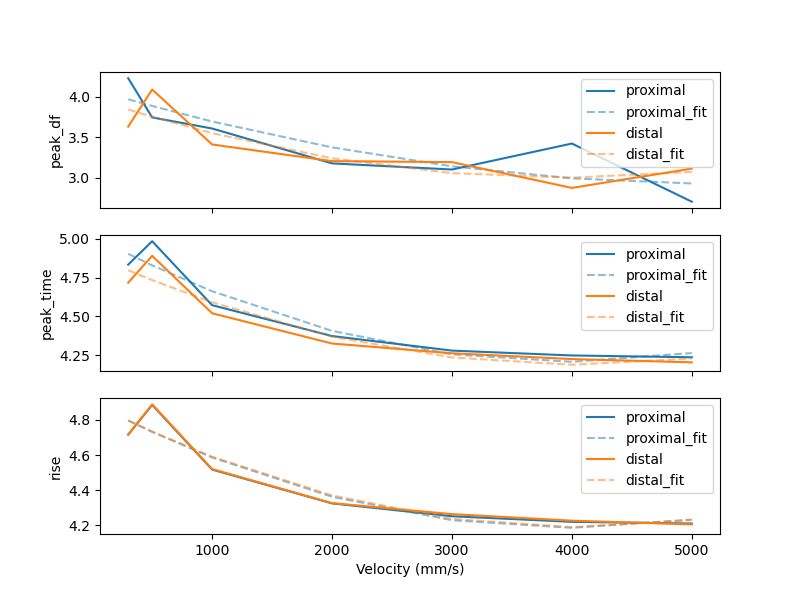

In [5]:
vel_data_fig, vel_data_ax = plt.subplots(3, sharex=True, figsize=(8, 6))
for ax, m in zip(vel_data_ax, metrics):
    for l, c in zip(locations, ["C0", "C1"]):
        ax.plot(exp["velocities"], np.mean(exp[l][m], axis=1), c=c, label=l)
        fit = exp_fits[l][m](exp["velocities"])
        ax.plot(exp["velocities"], fit, label=l + "_fit", c=c, linestyle="--", alpha=.5)
        ax.set_ylabel(m)
        ax.legend()

vel_data_ax[-1].set_xlabel("Velocity (mm/s)")
vel_data_fig.show()

### Velocity Tuning of Biexponential Taus

In [6]:
# fit_h5 = base_path + "velocity_tuning_data/velocity_tau_fits.h5"
fit_h5 = base_path + "velocity_tuning_data/manual_tau_fits.h5"

with h5.File(fit_h5, "r") as f:
    tau_fits = unpack_hdf(f)

<IPython.core.display.Javascript object>


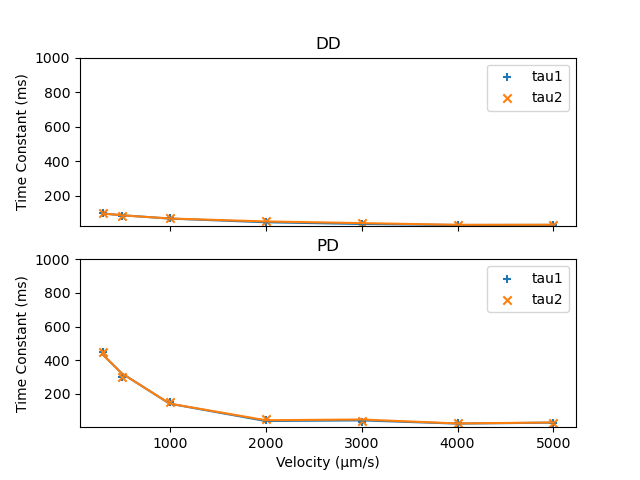

In [7]:
tau_polys, norm_tau_polys = {}, {}
tune_fig, tune_ax = plt.subplots(2, sharex=True)

for ax, (depth, vels) in zip(tune_ax, tau_fits.items()):
    tau_polys[depth], norm_tau_polys[depth] = {}, {}
    for t, m in [("tau1", "+"), ("tau2", "x")]:
        taus = np.array([vels[v][t] for v in exp["velocities"]]) * 1000  # from s to ms
        norm_taus = taus / np.max(taus)
        coefs = np.polyfit(exp["velocities"], taus, deg=4)
        norm_coefs = np.polyfit(exp["velocities"], norm_taus, deg=4)
        tau_polys[depth][t] = np.poly1d(coefs)
        norm_tau_polys[depth][t] = np.poly1d(norm_coefs)
        ax.scatter(exp["velocities"], taus, marker=m, label=t)
        ax.plot(exp["velocities"], tau_polys[depth][t](exp["velocities"]))
    ax.set_title(depth)

for a in tune_ax:
    a.set_ylabel("Time Constant (ms)")
    a.set_ylim(None, 1000)
    a.legend()
    
tune_ax[1].set_xlabel("Velocity (μm/s)")
tune_fig.show()

### Seung Bipolar Distribution
Values eyeballed from `Space-time wiring specificity supports direction selectivity in the retina (Kim et al., 2014)`.

<IPython.core.display.Javascript object>


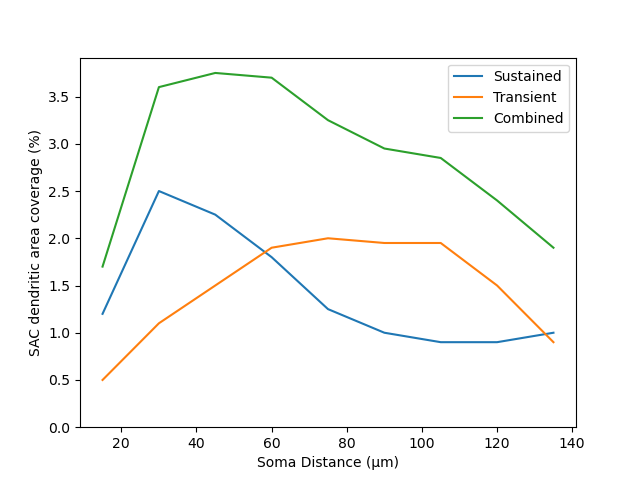

In [8]:
seung_soma_dist = np.arange(15, 150, 15)
seung_sust_coverage = np.array([0.012, 0.025, 0.0225, 0.018, 0.0125, 0.01, 0.009, 0.009, 0.01])
seung_trans_coverage = np.array([0.005, 0.011, 0.015, 0.019, 0.02, 0.0195, 0.0195, 0.015, 0.009])
seung_combo_coverage = seung_sust_coverage + seung_trans_coverage

seung_coverage_fig, seung_coverage_ax = plt.subplots(1)
seung_coverage_ax.plot(seung_soma_dist, seung_sust_coverage * 100, label="Sustained")
seung_coverage_ax.plot(seung_soma_dist, seung_trans_coverage * 100, label="Transient")
seung_coverage_ax.plot(seung_soma_dist, seung_combo_coverage * 100, label="Combined")

seung_coverage_ax.set_ylim(0)
seung_coverage_ax.set_xlabel("Soma Distance (μm)")
seung_coverage_ax.set_ylabel("SAC dendritic area coverage (%)")
seung_coverage_ax.legend()
seung_coverage_fig.show()

### Use inverse transform sampling to create probability distributions that mimic the shape of these mearurements

These functions can be used to distribute a given number of bipolar inputs over a sac dendrite. Note that the desired end % coverage of the model SACs will need to be achieved by picking the appropriate number of samples.

<IPython.core.display.Javascript object>


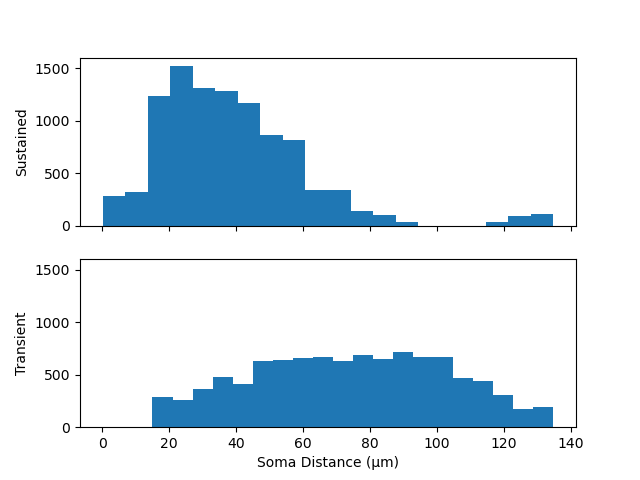

In [9]:
from_zero = True  # probabilities from zero, instead of positive floor

seung_sust_f = inverse_transform(
    seung_soma_dist, 
    seung_sust_coverage - (np.min(seung_sust_coverage) if from_zero else 0)
)
seung_trans_f = inverse_transform(
    seung_soma_dist,
    seung_trans_coverage - (np.min(seung_trans_coverage) if from_zero else 0)
)

seung_bp_hist_fig, seung_bp_hist_ax = plt.subplots(2, sharex=True, sharey=True)
seung_bp_hist_ax[0].hist(seung_sust_f(np.random.uniform(size=10000)), bins=20)
seung_bp_hist_ax[1].hist(seung_trans_f(np.random.uniform(size=10000)), bins=20)

seung_bp_hist_ax[0].set_ylabel("Sustained")
seung_bp_hist_ax[1].set_ylabel("Transient")
seung_bp_hist_ax[1].set_xlabel("Soma Distance (μm)")
seung_bp_hist_fig.show()

### Ding Bipolar Distribution
Values eyeballed from `Species-specific wiring for direction selectivity in the mammalian retina (Ding et al., 2016`. Figure 2e, type 7 (yellow line) used for sustained, and combined type 5s (grey line) used for transient.

<IPython.core.display.Javascript object>


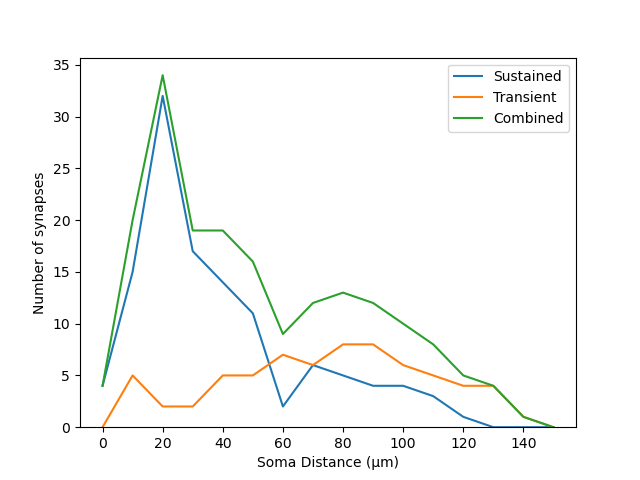

total sustained: 118
total transient: 68


In [10]:
ding_soma_dist = np.arange(0, 160, 10)
ding_sust_coverage = np.array([4, 15, 32, 17, 14, 11, 2, 6, 5, 4, 4, 3, 1, 0, 0, 0])
ding_all5_coverage = np.array([0, 5, 10, 7, 13, 11, 12, 6, 23, 19, 10, 8, 5, 4, 1, 1])
ding_5t_coverage = np.array([0, 5, 2, 2, 5, 5, 7, 6, 8, 8, 6, 5, 4, 4, 1, 0])

# ding_trans_coverage = ding_all5_coverage
ding_trans_coverage = ding_5t_coverage
ding_combo_coverage = ding_sust_coverage + ding_trans_coverage


ding_coverage_fig, ding_coverage_ax = plt.subplots(1)
ding_coverage_ax.plot(ding_soma_dist, ding_sust_coverage, label="Sustained")
ding_coverage_ax.plot(ding_soma_dist, ding_trans_coverage, label="Transient")
ding_coverage_ax.plot(ding_soma_dist, ding_combo_coverage, label="Combined")

ding_coverage_ax.set_ylim(0)
ding_coverage_ax.set_xlabel("Soma Distance (μm)")
ding_coverage_ax.set_ylabel("Number of synapses")
ding_coverage_ax.legend()
ding_coverage_fig.show()

print("total sustained:", np.sum(ding_sust_coverage))
print("total transient:", np.sum(ding_trans_coverage))

<IPython.core.display.Javascript object>


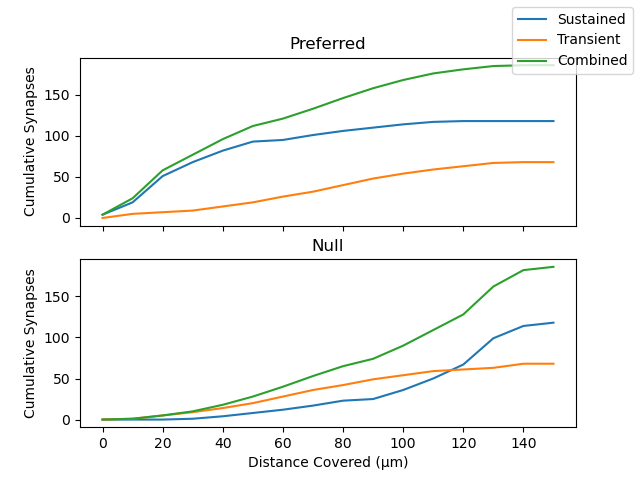

In [11]:
ding_cum_fig, ding_cum_ax = plt.subplots(2, sharex=True, sharey=True)

ding_cum_ax[0].plot(ding_soma_dist, np.cumsum(ding_sust_coverage), label="Sustained")
ding_cum_ax[0].plot(ding_soma_dist, np.cumsum(ding_trans_coverage), label="Transient")
ding_cum_ax[0].plot(ding_soma_dist, np.cumsum(ding_combo_coverage), label="Combined")

ding_cum_ax[1].plot(ding_soma_dist, np.cumsum(np.flip(ding_sust_coverage)))
ding_cum_ax[1].plot(ding_soma_dist, np.cumsum(np.flip(ding_trans_coverage)))
ding_cum_ax[1].plot(ding_soma_dist, np.cumsum(np.flip(ding_combo_coverage)))

ding_cum_ax[0].set_title("Preferred")
ding_cum_ax[1].set_title("Null")
for ax in ding_cum_ax:
    ax.set_ylabel("Cumulative Synapses")
ding_cum_ax[1].set_xlabel("Distance Covered (μm)")
ding_cum_fig.legend()

<IPython.core.display.Javascript object>


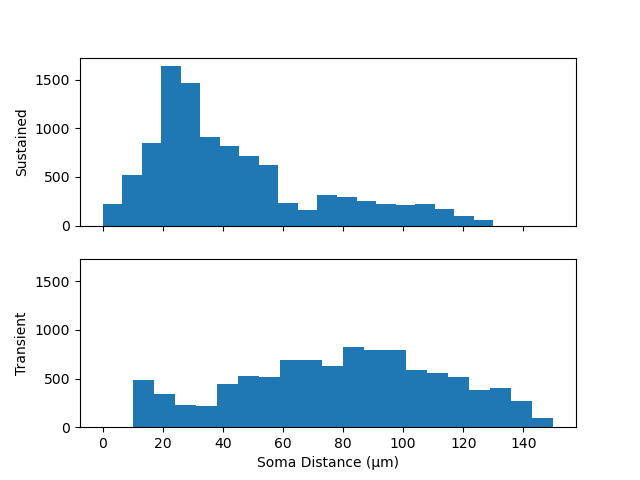

In [12]:
bin_size = ding_soma_dist[1] - ding_soma_dist[0]  # shift over so points are ends of bins
ding_sust_f = inverse_transform(ding_soma_dist + bin_size, ding_sust_coverage)
ding_trans_f = inverse_transform(ding_soma_dist + bin_size, ding_trans_coverage)

ding_bp_hist_fig, ding_bp_hist_ax = plt.subplots(2, sharex=True, sharey=True)
ding_bp_hist_ax[0].hist(ding_sust_f(np.random.uniform(size=10000)), bins=20)
ding_bp_hist_ax[1].hist(ding_trans_f(np.random.uniform(size=10000)), bins=20)

ding_bp_hist_ax[0].set_ylabel("Sustained")
ding_bp_hist_ax[1].set_ylabel("Transient")
ding_bp_hist_ax[1].set_xlabel("Soma Distance (μm)")
ding_bp_hist_fig.show()

### Release Rates

In [13]:
# quanta_h5 = "/mnt/Data/prerna_velocity/2021_06_30/waveforms/quantum_pack.h5"
# quanta_h5 = "/mnt/Data/prerna_velocity/2021_05_12_v2/waveforms/quantum_pack.h5"
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]

# NOTE: faked rates for testing. Sust into square, trans cut off early
# release_rates["PD"][500]["static_spot"][1:] = release_rates["PD"][500]["static_spot"][6]
# release_rates["DD"][500]["static_spot"][50:] = 0

<IPython.core.display.Javascript object>


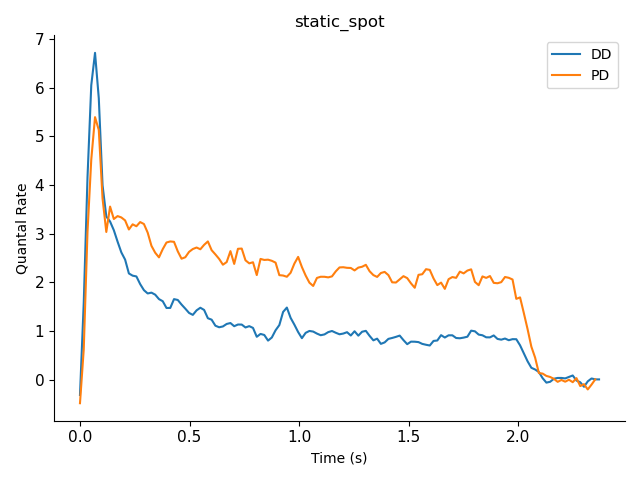

In [14]:
vel = 500
rate_dt = 1 / 58.25

rate_fig, rate_ax = plt.subplots(len(release_rates["DD"][vel]), sharex=True, sharey=True)
rate_ax = [rate_ax] if len(release_rates["DD"][vel]) == 1 else rate_ax
for depth, stims in release_rates.items():
    for ax, (stim, rate) in zip(rate_ax, stims[vel].items()):
        ax.plot(np.arange(len(rate)) * rate_dt, rate, label=depth)

for ax, stim in zip(rate_ax, release_rates["DD"][vel].keys()):
    ax.legend()
    ax.set_title(stim)
    ax.set_ylabel("Quantal Rate")
    clean_axes(ax)

rate_ax[-1].set_xlabel("Time (s)")
rate_fig.tight_layout()
rate_fig.show()

<IPython.core.display.Javascript object>


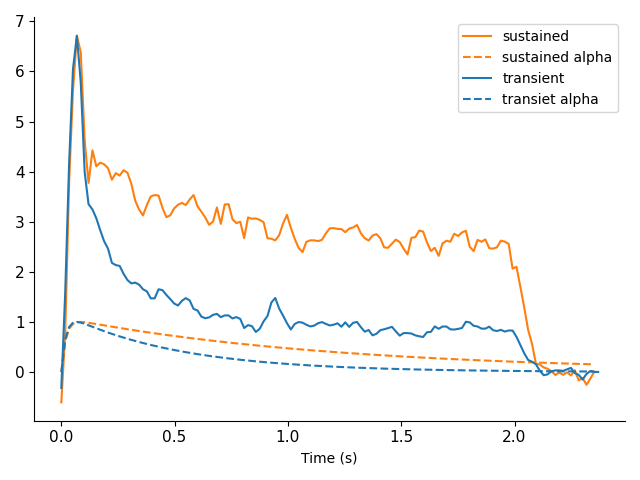

In [15]:
# sust = (
#     release_rates["PD"][500]["static_spot"] 
#     / np.max(release_rates["PD"][500]["static_spot"])
# )
# trans = (
#     release_rates["DD"][500]["static_spot"] 
#     / np.max(release_rates["DD"][500]["static_spot"])
# )

trans = release_rates["DD"][500]["static_spot"]
peak_ratio = np.max(trans) / np.max(release_rates["PD"][500]["static_spot"])
sust = release_rates["PD"][500]["static_spot"] * peak_ratio

pts = len(sust)

fitter = BiexpFitter(1, 10, norm_amp=True)
biexp_sust = fitter.model(
    t=np.arange(pts), 
    tau1=0.02 / rate_dt, # convert to match resulting sample-rate to data
    tau2=1.2 / rate_dt, 
    y0=1.,
)[0]
biexp_trans = fitter.model(
    t=np.arange(pts), 
    tau1=0.02 / rate_dt, # convert to match resulting sample-rate to data
    tau2=0.5 / rate_dt, 
    y0=1.,
)[0]
biexp_xaxis = np.arange(pts) * rate_dt

alpha_comp_fig, alpha_comp_ax = plt.subplots(1)
alpha_comp_ax.plot(
    np.arange(len(sust)) * rate_dt, 
    sust,
    c="C1",
    label="sustained"
)
alpha_comp_ax.plot(
    biexp_xaxis,
    biexp_sust,
    c="C1",
    linestyle="--",
    label="sustained alpha"
)
alpha_comp_ax.plot(
    np.arange(len(trans)) * rate_dt, 
    trans, 
    c="C0",
    label="transient"
)
alpha_comp_ax.plot(
    biexp_xaxis,
    biexp_trans,
    c="C0",
    linestyle="--",
    label="transiet alpha"
)
clean_axes(alpha_comp_ax)
alpha_comp_ax.legend()
alpha_comp_ax.set_xlabel("Time (s)")
alpha_comp_fig.tight_layout()
alpha_comp_fig.show()

In [16]:
# stim = "snake"
# stim = "moving_spot"
stim = "static_spot"
rates = {
#     "trans": release_rates["DD"][500][stim] * 2.,
#     "sust": release_rates["PD"][500][stim] * 1.8,
    "trans": trans * 1.,
    "sust": sust * 1.,
}

interp_dt = 1 / 1000  # for model
dt_conv = rate_dt / interp_dt
interp_rates = {
    bp: np.interp(
        np.arange(np.ceil(len(rate) * dt_conv)) * interp_dt,
        np.arange(len(rate)) * rate_dt,
        rate
    ) 
    for bp, rate in rates.items()
}

# bp_releasers = {
#     "sust": train_maker(sust_rate, rate_dt),
#     "trans": train_maker(trans_rate, rate_dt)
# }
release_scale = 0.06
bp_releasers = {
    "sust": train_maker(interp_rates["sust"] * release_scale, interp_dt) ,
    "trans": train_maker(interp_rates["trans"] * release_scale, interp_dt)
}
print("release rate recording freq: %.2f" % (1 / rate_dt))
print("target simulation freq: %.2f" % (1 / interp_dt))
print("rate conversion factor: %.2f" % dt_conv)

release rate recording freq: 58.25
target simulation freq: 1000.00
rate conversion factor: 17.17


<IPython.core.display.Javascript object>


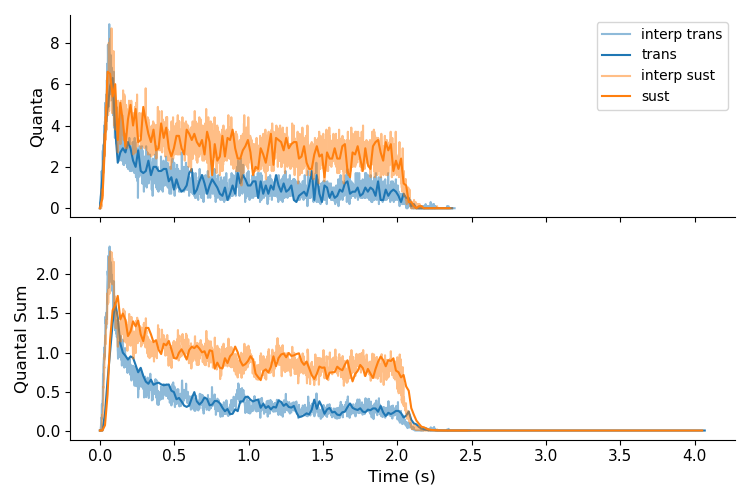

In [17]:
reps = 10
rng = np.random.default_rng()

rate_poisson_fig, rate_poisson_ax = plt.subplots(2, sharex=True, figsize=(7.5, 5))

for bp, c in zip(rates.keys(), ["C0", "C1"]):
    rate_x = np.arange(len(rates[bp])) * rate_dt
    interp_x = np.arange(len(interp_rates[bp])) * interp_dt
    
    total_quanta = np.sum([poisson_of_release(rng, rates[bp]) for _ in range(reps)], axis=0)
    quantal_sum = sum_quanta(
        total_quanta,
        np.arange(len(total_quanta)) * rate_dt, quantum_pack["quantum"], 
        rate_dt
    ) / reps
    quanta = total_quanta / reps
    
    interp_total_quanta = np.sum(
        [poisson_of_release(rng, interp_rates[bp]) for _ in range(reps)], axis=0)
    interp_quantal_sum = sum_quanta(
        interp_total_quanta,
        np.arange(len(interp_total_quanta)) * interp_dt, quantum_pack["quantum"], 
        interp_dt
    ) / reps
    interp_quanta = interp_total_quanta / reps
    
    interp_rpq_sum_xaxis = np.arange(len(interp_quantal_sum)) * interp_dt
    rate_poisson_ax[0].plot(
        np.arange(len(interp_total_quanta)) * interp_dt, interp_quanta,
        label="interp " + bp, 
        alpha=0.5,
        c=c,
    )
    rate_poisson_ax[1].plot(interp_rpq_sum_xaxis, interp_quantal_sum, alpha=0.5, c=c)
    
    rpq_sum_xaxis = np.arange(len(quantal_sum)) * rate_dt
    rate_poisson_ax[0].plot(
        np.arange(len(total_quanta)) * rate_dt, quanta, label=bp, c=c)
    rate_poisson_ax[1].plot(rpq_sum_xaxis, quantal_sum, c=c)
    

rate_poisson_ax[0].set_ylabel("Quanta", fontsize=12)
rate_poisson_ax[1].set_ylabel("Quantal Sum", fontsize=12)
rate_poisson_ax[1].set_xlabel("Time (s)", fontsize=12)
rate_poisson_ax[0].legend()
clean_axes(rate_poisson_ax)
rate_poisson_fig.tight_layout()
rate_poisson_fig.show()

### Configs

#### Notes on Vlasists 2016 params:
- They say that they either used 100 or 200 Ra, depending. So, try out 200 (100 is default).
- Rm set to 21700 Ω-cm² (g_pas = 1 / Rm)
- they have their mini taus described here as 0.14ms rise / 0.54ms decay
- minis peaked at 313 pS, directional stimuli were "3 vesicles" (939 pS)

In [18]:
dist_bps = {
    "bp_props": {
        "sust": {"tau1": 100, "tau2": 760, "rev": 0, "weight": .000012, "delay": 0},
        "trans": { "tau1": 72, "tau2":  600, "rev": 0, "weight": .000012, "delay": 0},    
    },
    "bp_locs": {
        "sust": ding_sust_f(np.random.uniform(size=6)).tolist(), # 6 
        "trans": ding_trans_f(np.random.uniform(size=6)).tolist(),  # 12
    },
    "gaba_props": {
        "loc": [15],  # distance from soma [um]
        "thresh": -50,  # pre-synaptic release threshold
        "tau1": 25,  # inhibitory conductance rise tau [ms]
        "tau2": 150,  # inhibitory conductance decay tau [ms]
        "rev": -60,  # inhibitory reversal potential [mV]
        "weight": .0012,  # weight of inhibitory NetCons [uS]
        "delay": .5,
    },
}

toy_dist_bps = {
    "bp_props": {
#         "sust": {"tau1": 10, "tau2": 40, "rev": 0, "weight": .0001, "delay": 0},
#         "trans": { "tau1": .1, "tau2":  15, "rev": 0, "weight": .0001, "delay": 0},    
#         "trans": { "tau1": .1, "tau2":  100, "rev": 0, "weight": .00002, "delay": 0},
        
        "sust": {"tau1": 10, "tau2": 250, "rev": 0, "weight": .000025, "delay": 0},
        "trans": {"tau1": .1, "tau2":  150, "rev": 0, "weight": .000025, "delay": 0},
        
#         "sust": {"tau1": 10, "tau2": 12.5, "rev": 0, "weight": .00005, "delay": 0},
#         "trans": { "tau1": .1, "tau2":  10, "rev": 0, "weight": .00005, "delay": 0},    
    },
    "bp_locs": {
        "sust": ding_sust_f(np.random.uniform(size=14)).tolist(), # 6 
        "trans": ding_trans_f(np.random.uniform(size=7)).tolist(),  # 12
    },
    "gaba_props": {
        "locs": [15],  # distance from soma [um]
        "thresh": -50,  # pre-synaptic release threshold
        "tau1": 10,  # inhibitory conductance rise tau [ms]
        "tau2": 120,  # inhibitory conductance decay tau [ms]
        "rev": -60,  # inhibitory reversal potential [mV]
        "weight": .0012,  # weight of inhibitory NetCons [uS]
#         "weight": .005,  # weight of inhibitory NetCons [uS]
        "delay": 0,
#         "delay": .5,
    },
}

fit_tau_toy_bps = {
    "bp_props": {
        "sust": {"tau1": 100, "tau2": 760, "rev": 0, "weight": .0002, "delay": 0},
        "trans": { "tau1": 72, "tau2":  600, "rev": 0, "weight": .0002, "delay": 0},        
    },
    "bp_locs": {"sust": [5], "trans": [15, 35, 55]},
}

fit_tau_2_bps = {
    "bp_props": {
        "sust": {"tau1": 100, "tau2": 760, "rev": 0, "weight": .0004, "delay": 0},
        "trans": { "tau1": 72, "tau2":  600, "rev": 0, "weight": .0004, "delay": 0},        
    },
    "bp_locs": {"sust": [5], "trans": [55]},
}

toy_bps = {
    "bp_props": {
        "sust": {"tau1": 20, "tau2": 100, "rev": 0, "weight": .0003, "delay": 0},
        "trans": { "tau1": .1, "tau2":  15, "rev": 0, "weight": .0004, "delay": 0},
    },
#     "bp_locs": {"sust": [5], "trans": [15, 25, 35, 55, 75, 95]},
    "bp_locs": {"sust": [5], "trans": [20, 35, 50]},
}

uni_fall_bps = {
    "bp_props": {
        "sust": {"tau1": .14, "tau2": .54, "rev": 0, "weight": .0010, "delay": 0},
        "trans": { "tau1": .14, "tau2":  .54, "rev": 0, "weight": .0010, "delay": 0},    
#         "sust": {"tau1": .14, "tau2": 40, "rev": 0, "weight": .00010, "delay": 0},
#         "trans": { "tau1": .14, "tau2":  20, "rev": 0, "weight": .0001, "delay": 0},    
    },
    "bp_locs": {"sust": [5], "trans": [10, 15, 25, 35, 45, 65, 85, 105]},
}

toy_gaba_props = {
    "locs": [15],  # distance from soma [um]
    "thresh": -50,  # pre-synaptic release threshold
    "tau1": .1,  # inhibitory conductance rise tau [ms]
#     "tau2": 60,  # inhibitory conductance decay tau [ms]
    "tau2": 100,  # inhibitory conductance decay tau [ms]
    "rev": -60,  # inhibitory reversal potential [mV]
    "weight": .001,  # weight of inhibitory NetCons [uS]
#     "delay": .5,
    "delay": 0.,
}

toy_quanta_bps = {
    "bp_props": {
#         "sust": {"tau1": .14, "tau2": 1., "rev": 0, "weight": .0003, "delay": 0},
#         "trans": { "tau1": .14, "tau2":  1., "rev": 0, "weight": .0003, "delay": 0},
#         "sust": {"tau1": 0.14, "tau2": 0.54, "rev": 0, "weight": .000313 * .25, "delay": 0},
#         "trans": { "tau1": 0.14, "tau2":  0.54, "rev": 0, "weight": .000313 * .25, "delay": 0},    
        "sust": {"tau1": 0.14, "tau2": 0.54, "rev": 0, "weight": .000313 * .5, "delay": 0},
        "trans": { "tau1": 0.14, "tau2":  0.54, "rev": 0, "weight": .000313 * .5, "delay": 0},    
    },
#     "bp_locs": {"sust": [5], "trans": [20, 35, 50, 65, 80]},
#     "bp_locs": {"sust": [5], "trans": [35, 50, 65]},
#     "bp_locs": {"sust": [5], "trans": [25, 50, 75, 100]},
    "bp_locs": {
        "sust": [10, 20, 25, 30, 40, 50], 
        "trans": [20, 40, 50, 60, 70, 75, 80, 85, 90, 100, 110, 120]
    },
    
    "gaba_props": {
#         "locs": [15],  # distance from soma [um]
        "locs": [15, 25, 35, 50, 60],  # distance from soma [um]
#         "locs": [15, 25, 35],  # distance from soma [um]
#         "thresh": -40,  # pre-synaptic release threshold
        "thresh": -50,  # pre-synaptic release threshold
        "tau1": 25,  # inhibitory conductance rise tau [ms]
        "tau2": 150,  # inhibitory conductance decay tau [ms]
        "rev": -60,  # inhibitory reversal potential [mV]
#         "weight": .0012,  # weight of inhibitory NetCons [uS]
        "weight": .0015,  # weight of inhibitory NetCons [uS]
        "delay": .5,
    },
}

dist_quanta_bps = {
    "bp_props": {
#         "sust": {"tau1": 0.1, "tau2": 4., "rev": 0, "weight": .00001, "delay": 0},
#         "trans": { "tau1": 0.1, "tau2":  4., "rev": 0, "weight": .00001, "delay": 0},    
#         "sust": {"tau1": 0.1, "tau2": 1., "rev": 0, "weight": .00005, "delay": 0},
#         "trans": { "tau1": 0.1, "tau2":  1., "rev": 0, "weight": .00005, "delay": 0},    
        "sust": {"tau1": 0.14, "tau2": 0.54, "rev": 0, "weight": .000313 * .25, "delay": 0},
        "trans": { "tau1": 0.14, "tau2":  0.54, "rev": 0, "weight": .000313 * .25, "delay": 0},    
    },
    "bp_locs": {
        "sust": ding_sust_f(np.random.uniform(size=6)).tolist(), # 6 
        "trans": ding_trans_f(np.random.uniform(size=12)).tolist(),  # 12
    },
    "gaba_props": {
#         "locs": [15],  # distance from soma [um]
        "locs": [15, 25, 35, 50, 60],  # distance from soma [um]
#         "locs": [15, 25, 35],  # distance from soma [um]
        "thresh": -50,  # pre-synaptic release threshold
        "tau1": 25,  # inhibitory conductance rise tau [ms]
        "tau2": 150,  # inhibitory conductance decay tau [ms]
        "rev": -60,  # inhibitory reversal potential [mV]
#         "weight": .0012,  # weight of inhibitory NetCons [uS]
        "weight": .0015,  # weight of inhibitory NetCons [uS]
        "delay": .5,
    },
}

def tau_funs(depth):
    return {
        "tau1": (lambda v, _: tau_polys[depth]["tau1"](v)),
        "tau2": (lambda v, _: tau_polys[depth]["tau2"](v)),    
    }

def norm_tau_funs(depth):
    return {
        "tau1": (lambda v, t1: t1 * norm_tau_polys[depth]["tau1"](v)),
        "tau2": (lambda v, t2: t2 * norm_tau_polys[depth]["tau2"](v)),    
    }


def bp_scaling(tau_scaling_funs=None):
    if tau_scaling_funs is None:
        def tau_scaling_funs(_depth):
            return {
                "tau1": (lambda _, t1: t1),
                "tau2": (lambda _, t2: t2),
            }
    return {
        "vel_scaling": True,
        "bp_vel_scaling": {
            "sust":
                {
                    "weight": (lambda v, w: w * norm_fits["proximal"]["peak_df"](v * 1000)),
                    **tau_scaling_funs("PD"),
                },
            "trans":
                {
                    "weight": (lambda v, w: w * norm_fits["distal"]["peak_df"](v * 1000)),
                    **tau_scaling_funs("DD"),
                },
        },
}

def gaba_vel_scaling(vel, weight):
    return gaba_peak_fit(vel * 1000) * weight

vlasists = {
    "soma_gleak_hh": 1 / 21700,
    "dend_gleak_hh": 1 / 21700,
    "soma_ra": 150,
    "dend_ra": 150,
}


high_ca = {
    "term_cat": 0., #0.003,  # 0.0003,
#     "term_cat": 0.,  # 0.0003,
    "term_cal": 0.000,
    "term_can": 0.0003, # 0.0003
    "term_cap": 0.0001, # 0.0003
    "term_na": 0.0001,
    "term_k": 0.0,
    "soma_k": .05,
    "initial_k": 0.01,
#     "term_l": 1,
#     "term_diam": 1,
    "term_nav1_8": 25e-5, #60e-3,
#     "term_nav1_9": 0.,
    "term_kv3_3": 0.05, #0.05,
}

no_sink = {"sink_dend_locs": [], "sink_orders": []}

basic_toy_params = {
    **toy_bps,
    **bp_scaling(tau_scaling_funs=None),
    **vlasists,
    "gaba_props": toy_gaba_props,
}

scaled_toy_params = {
    **toy_bps,
    **bp_scaling(tau_scaling_funs=norm_tau_funs),
    **vlasists,
    **high_ca,
    "gaba_props": toy_gaba_props,
}

fit_tau_toy_params = {
    **fit_tau_toy_bps,
    **bp_scaling(tau_scaling_funs=tau_funs),
    **vlasists,
}

fit_tau_2bp_params = {
    **fit_tau_2_bps,
    **bp_scaling(tau_scaling_funs=tau_funs),
    **vlasists,
}

bp_dist_params = {
    **dist_bps,
    **bp_scaling(tau_scaling_funs=tau_funs),
    **vlasists,
}

toy_dist_params = {
    **toy_dist_bps,
#     **bp_scaling(tau_scaling_funs=None),
    **bp_scaling(tau_scaling_funs=norm_tau_funs),
    **vlasists,
    **high_ca,
}

falloff_params = {
    **uni_fall_bps,
    **vlasists,
}

quanta_toy_params = {
    **toy_quanta_bps,
    **bp_scaling(tau_scaling_funs=None),
    **vlasists,
    **high_ca,
    **no_sink,
    "gaba_vel_scaling": gaba_vel_scaling,
    "bp_releasers": bp_releasers,
}

dist_quanta_params = {
    **dist_quanta_bps,
    **bp_scaling(tau_scaling_funs=None),
    **vlasists,
    **high_ca,
    **no_sink,
    "gaba_vel_scaling": gaba_vel_scaling,
    "bp_releasers": bp_releasers,
}

### Legacy params

In [19]:
old_params = {
    "soma_l": 10,
    "soma_diam": 10,
    "soma_ra": 150,
    "initial_dend_diam": 0.2,
    "dend_diam": 0.2,
    "dend_l": 140,
    "dend_ra": 150,
    "soma_na": 0,
    "soma_k": 0,
    "soma_km": 0,
    "soma_gleak_hh": 0.0001667,
    "soma_eleak_hh": -70.0,
    "dend_na": 0.0,
    "dend_k": 0,
    "dend_km": 0,
    "initial_k": 0,
    "initial_km": 0,
    "dend_gleak_hh": 0.0001667,
    "dend_eleak_hh": -70.0,
    "term_cat": 0.0003,
    "term_cal": 0.0003,
    "term_can": 0,
    "term_cap": 0,
    "bp_props": {
        "sust": { "tau1": 0.1, "tau2": 200, "rev": 0, "weight": 1e-05, "delay": 0},
        "trans": {"tau1": 0.1, "tau2": 200, "rev": 0, "weight": 1e-05, "delay": 0},
    },
    "loc_scaling": False,
    "vel_scaling": True,
    "gaba_props": {"locs": [15], "thresh": -50, "tau1": 10, "tau2": 120, "rev": -70, "weight": 0.0012, "delay": 0},
    "bp_locs": {
        "sust": ding_sust_f(np.random.uniform(size=14)).tolist(), # 6 
        "trans": ding_trans_f(np.random.uniform(size=7)).tolist(),  # 12
    },
    **bp_scaling(tau_scaling_funs=norm_tau_funs),
}

only_t_params = {
    "bp_props": {
        "sust": {"tau1": 10, "tau2": 250, "rev": 0, "weight": .000025, "delay": 0},
        "trans": {"tau1": .1, "tau2":  150, "rev": 0, "weight": .000025, "delay": 0},
    },
    "bp_locs": {
        "sust": ding_sust_f(np.random.uniform(size=14)).tolist(), # 6 
        "trans": ding_trans_f(np.random.uniform(size=7)).tolist(),  # 12
    },
    "gaba_props": {"locs": [15], "thresh": -50, "tau1": 10, "tau2": 120, "rev": -60, "weight": .005, "delay": 0,
    },
    "soma_gleak_hh": 1 / 21700,
    "dend_gleak_hh": 1 / 21700,
    "soma_ra": 150,
    "dend_ra": 150,
    "term_cat": 0.003,
    "term_cal": 0.,
    "term_can": 0,
    "term_cap": 0,
    "term_na": 0.00,
    "term_k": 0,
    "soma_k": .05,
    "initial_k": 0.01,
    **bp_scaling(tau_scaling_funs=norm_tau_funs),
}

### Load existing data, or run NEURON model to generate new data
Parameters can be provided to the `SacPair` class in the form of a dict which will be used to overwrite the default properties of the `Sac` objects generated (see `sac_pair.py`).

### Various example `.h5`s:

In [20]:
model_path = base_path + "model_runs/"
# save_name = "toy_test"
save_name = "toy_quanta_test"
# load_name = "toy_dist_test"
# load_name = "toy_dist_test_save_this_tau200"
# load_name = "toy_dist_250sust_150tran_onlyT"
# load_name = "toy_dist_250su_150tr_onlyT_example" # use this, good enough for ex I think
# load_name = "static_rate_quanta_dist"
# load_name = "static_rate_quanta_dist_5gaba"
# load_name = "static_rate_quanta_dist_5gaba_15_25_35_50_60"
# load_name = "static_rate_quanta_dist_gaba_15_25_35"
# load_name = "toy_quanta_5gaba_15_25_35_50_60"
load_name = "toy_quanta_2021_11_12"
# load_name = None

# toy_params = basic_toy_params
#toy_params = scaled_toy_params
# toy_params = fit_tau_toy_params
# toy_params = falloff_params
# toy_params = fit_tau_2bp_params
toy_params = quanta_toy_params

bp_dist_mode = False
# bp_dist_params = bp_dist_params
# bp_dist_params = toy_dist_params
# bp_dist_params = old_params
bp_dist_params = dist_quanta_params

vc_mode = False

if load_name is not None:
    with h5.File(os.path.join(model_path, load_name + ".h5"), "r") as f:
        data = unpack_hdf(f)
else:
    import sac_pair
    sac_params = bp_dist_params if bp_dist_mode else toy_params
    model = sac_pair.SacPair(sac_params=sac_params)
    runner = sac_pair.Runner(model, data_path=model_path)
    
    if vc_mode:
        runner.place_vc()
        save_name = "vc_" + save_name
    
    if bp_dist_mode:
        data = runner.bp_distribution_run(
            distributions={"sust": ding_sust_f, "trans": ding_trans_f},
            dist_trials=5,
            mirror=True,
#             velocities=[.1, .25, .5, .75, 1, 1.25, 1.5, 1.75, 2, 3, 4],
            velocities=[.1, .25, .5, .75, 1, 1.25, 1.5, 1.75, 2, 3, 4],
#             uniform_props={"tau1": 1, "tau2": 20},
            uniform_props=sac_params["bp_props"]["trans"],
            mech_trials=5,
            conds={"control", "no_gaba", "uniform", "no_mech"},
#             conds={"no_gaba"},
            #conds={"control", "no_gaba", "uniform", "no_mech"}
#             conds={"uniform", "no_mech"}
        )
    else:
        data = runner.velocity_mechanism_run(
#             velocities=[.1, .25, .5, .75, 1, 1.25, 1.5, 1.75, 2, 3, 4],
            velocities=[.1, .25, .5, .75, 1],
#             uniform_props={"tau1": 1, "tau2": 20},
            uniform_props=sac_params["bp_props"]["trans"],
#             conds={"control", "no_gaba", "uniform", "no_mech"},
            conds={"no_gaba", "no_mech"},
            mech_trials=10
        )
    
    pack_hdf(os.path.join(model_path, save_name), data)

# if bp_dist_mode:
#     model_params = json.loads(data[0]["control"]["model_params"])
#     exp_params = json.loads(data[0]["control"]["exp_params"])
#     exps = {k: v["data"] for k, v in data[0].items()}
# else:
#     model_params = json.loads(data["control"]["model_params"])
#     exp_params = json.loads(data["control"]["exp_params"])
#     exps = {k: v["data"] for k, v in data.items()}

# d = data[0] if bp_dist_mode else data
data = {0: data} if not bp_dist_mode else data
first_cond = list(data[0].keys())[0]
print("params condition: %s" % first_cond)
model_params = {i: json.loads(d[first_cond]["model_params"]) for i, d in data.items()}
exp_params = {i: json.loads(d[first_cond]["exp_params"]) for i, d in data.items()}
exps = {i: {k: v["data"] for k, v in d.items()} for i, d in data.items()}

for i in exps.keys():
    for cond in exps[i].keys():
        exps[i][cond]["combined_bps"] = {
            n: {
                m: np.sum(
                    [bp[m] for bps in sac.values() for bp in bps.values()], axis=0
                )
                for m in ["g", "i"]
            }
            for n, sac in exps[i][cond]["bps"].items()
        }
        exps[i][cond]["combined_gaba"] = {
            n: {
                m: np.sum([syn[m] for syn in sac.values()], axis=0)
                for m in ["g", "i"]
            }
            for n, sac in exps[i][cond]["gaba"].items()
        }

avg_exps = {i: apply_to_data(lambda a: np.mean(a, axis=0), e) for i, e in exps.items()}

params condition: no_gaba


In [21]:
# json.loads(data[0]["uniform"]["model_params"])

### Common axes, labels, and parameters generated or pulled from the control experiment data which apply to all conditions

In [22]:
dt = exp_params[0]["dt"]
rec_xaxis = np.arange(0, exp_params[0]["tstop"] + dt, dt)
velocities = exp_params[0]["velocities"]

### Experiment dict contents / shapes

In [23]:
print("Electrode recording dict keys:", [k for k in exps[0][first_cond]["soma"]["a"].keys()])
print("Synapse recording dict keys:", [k for k in exps[0][first_cond]["gaba"]["a"].keys()])
print("Recording shape:", exps[0][first_cond]["soma"]["a"]["v"].shape)

Electrode recording dict keys: ['cai', 'ica', 'v']
Synapse recording dict keys: [0, 1, 2, 3, 4]
Recording shape: (10, 5, 4001)


<IPython.core.display.Javascript object>


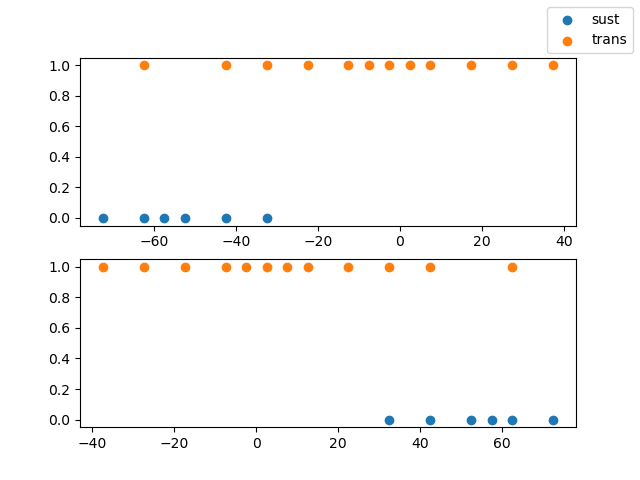

In [24]:
exp_idx = 0
ff, aa = plt.subplots(2)
a_locs = model_params[exp_idx]["a"]["bp_xy_locs"]
b_locs = model_params[exp_idx]["b"]["bp_xy_locs"]
aa[0].scatter(a_locs["sust"]["x"], a_locs["sust"]["y"] , label="sust")
aa[0].scatter(a_locs["trans"]["x"], np.array(a_locs["trans"]["y"]) + 1, label="trans")
aa[1].scatter(b_locs["sust"]["x"], b_locs["sust"]["y"])
aa[1].scatter(b_locs["trans"]["x"], np.array(b_locs["trans"]["y"]) + 1)
ff.legend()

### Model Schematic and Animation
Colours are normalized to the maximum values of their corresponding measures across all velocities and both SACs in a particular condition. Thus, for the matching visible components (e.g. 2nd trans BPCs or terminals), the colour scaling is shared.

- **soma:** membrane voltage at centre
- **terminal:** membrane voltage at tip (GABA pre-synapse)
- **bipolars:** conductance
- **GABA:** conductance

<IPython.core.display.Javascript object>


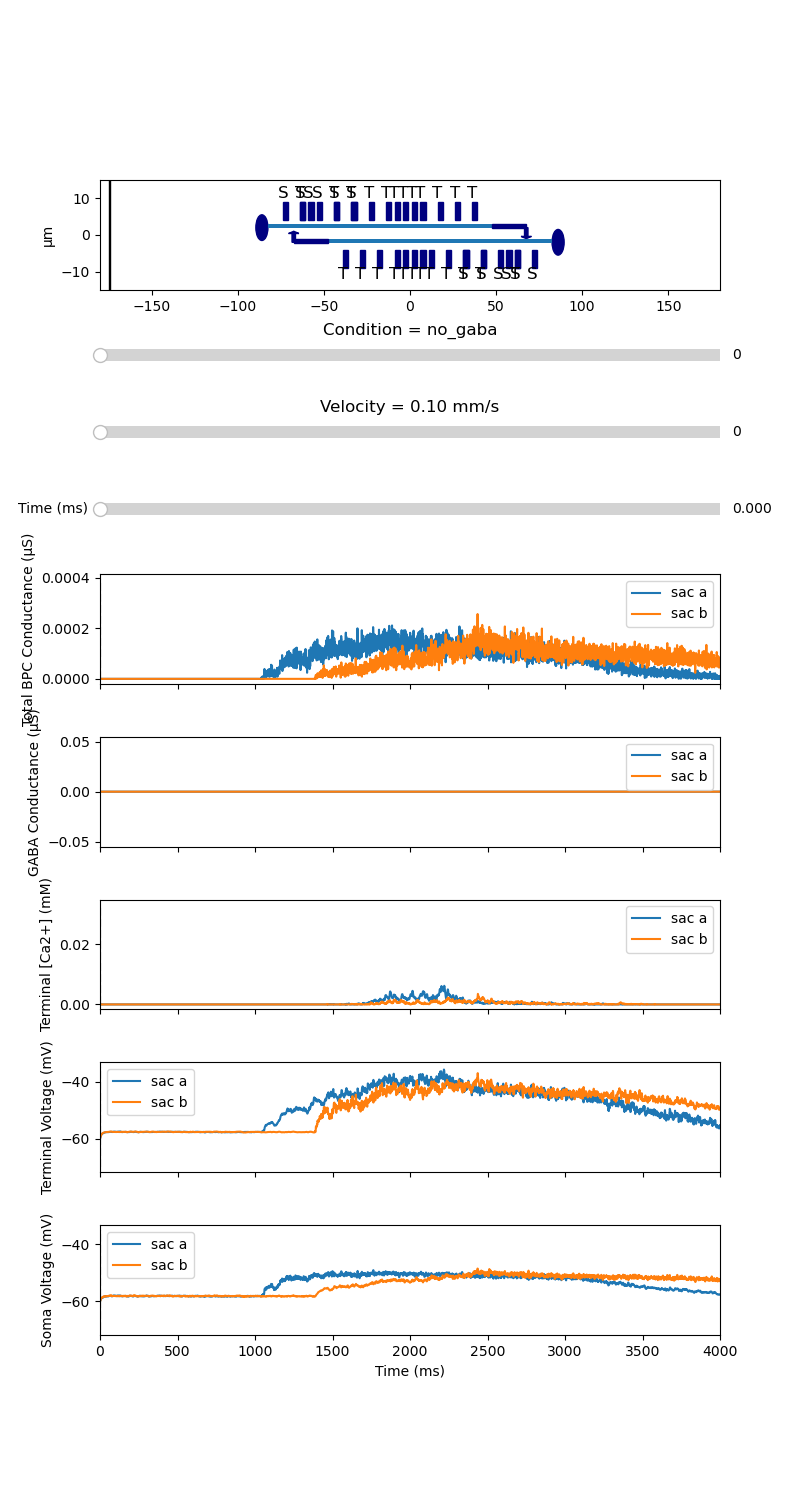

In [25]:
exp_idx = 0
sac_anim = SacSacAnimator(
    exps[exp_idx],
    exp_params[exp_idx],
    model_params[exp_idx], 
    reveal_time=False
)
sac_anim_fig, sac_anim_ax = sac_anim.build_interactive_fig(figsize=(8, 15))

### PN DSi measurements
Here the bar is simply moving in the same direction, over SAC A then SAC B, but we can use the signals in the opposing SACs to calculate a preferred minus null direction selective index.

- **peak:** Using the deflection from the minimum voltage
- **thresh_area:** Area under the voltage above a specified threshold
- **iCa**: Area of calcium current (polarity flipped to positive)
- **gaba:** Area of GABA conductance *applied* the *opposing* SAC  

In [26]:
thresh = -40
dsis = {
    i: { 
        cond: {
            "peak": pn_dsi(
                peak_vm_deflection(exp["term"]["a"]["v"]),
                peak_vm_deflection(exp["term"]["b"]["v"])
            ),
            "thresh_area": pn_dsi(
                thresholded_area(exp["term"]["a"]["v"], thresh),
                thresholded_area(exp["term"]["b"]["v"], thresh)
            ),
            "iCa": pn_dsi(
                np.sum(exp["term"]["a"]["ica"] * -1, axis=-1),
                np.sum(exp["term"]["b"]["ica"] * -1, axis=-1)
            ),
            "gaba": pn_dsi(
                np.sum(exp["combined_gaba"]["b"]["g"], axis=-1), 
                np.sum(exp["combined_gaba"]["a"]["g"], axis=-1)
            ),
            "peak_[Ca]": pn_dsi(
                np.max(exp["term"]["a"]["cai"], axis=-1),
                np.max(exp["term"]["b"]["cai"], axis=-1)
            ),
        }
        for cond, exp in es.items()
    } 
    for i, es in exps.items()
}

avg_dsis = {
    cond: {
        metric: np.mean([dsis[i][cond][metric] for i in dsis.keys()], axis=0)
        for metric in dsis[0][cond].keys()
    }
    for cond in dsis[0].keys()
}

### Velocity Tuning of PN DSi
The above measurements of PN DSi for each of the experimental conditions.
- **control:** sustained-transient bipolar time constants and reciprocal GABA are intact
- **no_gaba:** bipolar mechanism remains, while GABA synapses are removed
- **uniform:** bipolar time constants are all the same (no prox-distal difference)
- **no_mechs:** bipolar time constants are uniform, and GABA synapses are removed

<IPython.core.display.Javascript object>


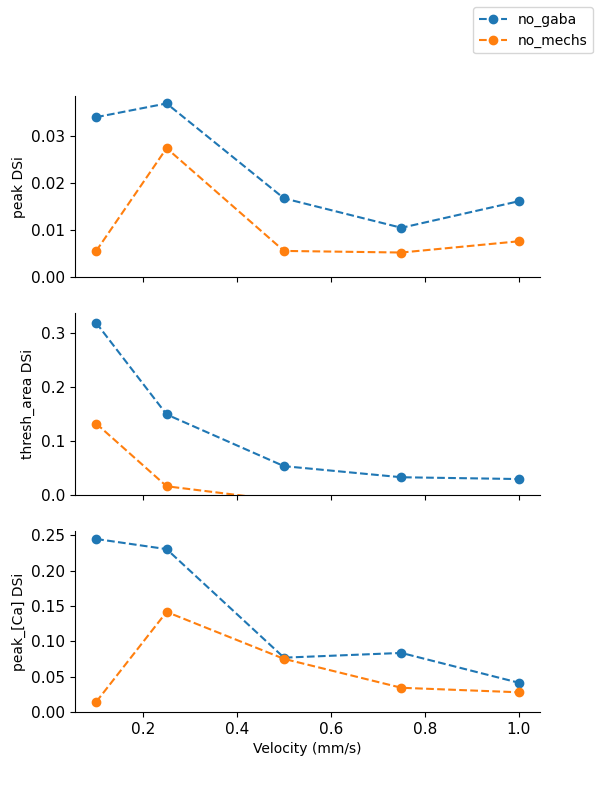

In [27]:
# show_metrics = list(avg_dsis[first_cond].keys())
show_metrics = ["peak", "thresh_area", "peak_[Ca]"]
dsi_fig, dsi_ax = plt.subplots(len(show_metrics), sharex=True, figsize=(6, 8))
for (cond, ds) in avg_dsis.items():
    for i, (a, m) in enumerate(zip(dsi_ax, show_metrics)):
        lbl = {"label": cond} if not i else {}  # only add label once for each condition
        a.plot(velocities, np.mean(ds[m], axis=0), linestyle="--", marker="o", **lbl)

for a, metric in zip(dsi_ax, show_metrics):
    a.set_ylabel("%s DSi" % metric)
    a.set_ylim(0)
    clean_axes(a)

dsi_ax[-1].set_xlabel("Velocity (mm/s)")
dsi_fig.legend()
dsi_fig.show()

### Highlight of the thresholded area metric

<IPython.core.display.Javascript object>


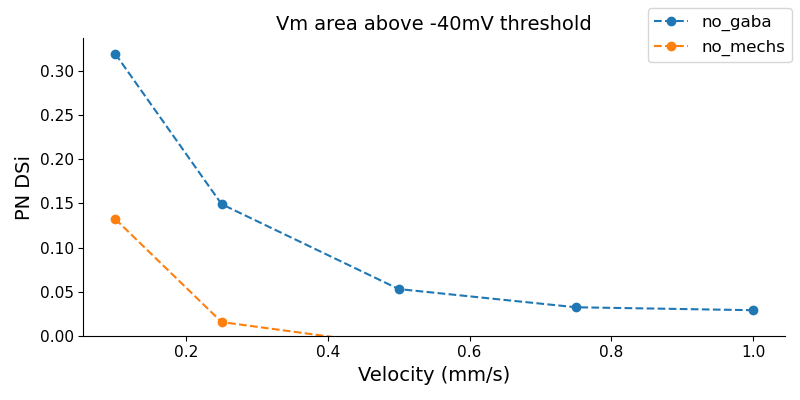

In [28]:
start_vel_idx = 0
end_vel_idx = None
area_dsi_fig, area_dsi_ax = plt.subplots(1, figsize=(8, 4))
for (cond, ds) in avg_dsis.items():
    area_dsi_ax.plot(
        velocities[start_vel_idx:end_vel_idx], 
        np.mean(ds["thresh_area"][:, start_vel_idx:end_vel_idx], axis=0),
        linestyle="--",
        marker="o",
        label=cond
    )

area_dsi_ax.set_title("Vm area above %imV threshold" % thresh, fontsize=14)
area_dsi_ax.set_ylabel("PN DSi", fontsize=14)
area_dsi_ax.set_xlabel("Velocity (mm/s)", fontsize=14)
area_dsi_ax.set_ylim(0)
clean_axes(area_dsi_ax)
area_dsi_fig.legend(fontsize=12)
area_dsi_fig.tight_layout()
area_dsi_fig.show()

### Terminal membrane voltage and (proximal) GABA conductance
Trial averages of membrane voltage (recorded at the distal tip) for each membrane, along with the GABA conductance they recieved proximal to their soma from the opposing SAC. Legend indicates the velocity (in mm/s) corresponding to each mean recording presented.

A figure is generated for each of the experimental conditions.

<IPython.core.display.Javascript object>


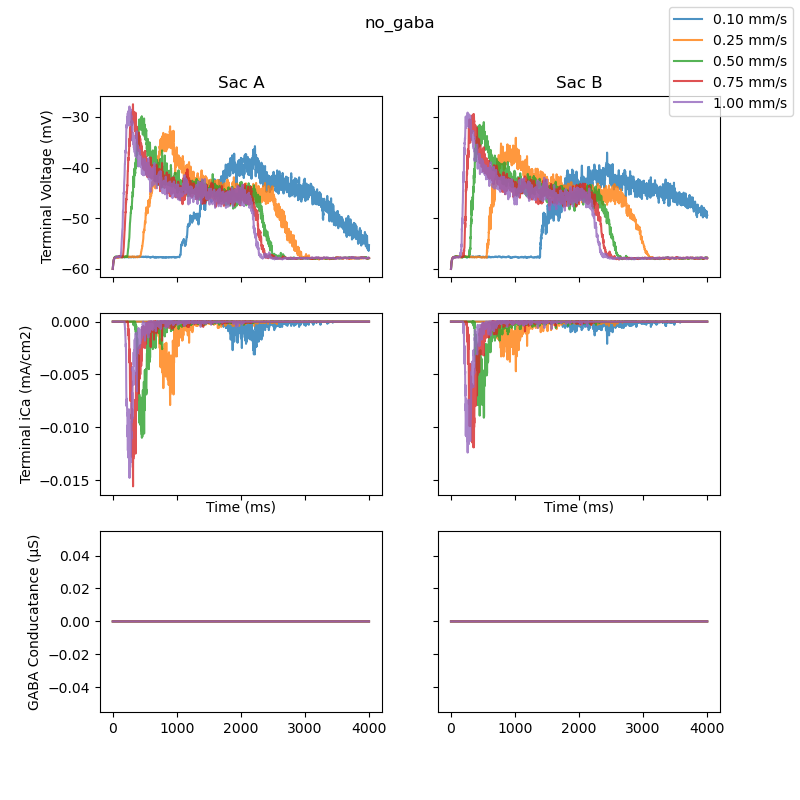

<IPython.core.display.Javascript object>


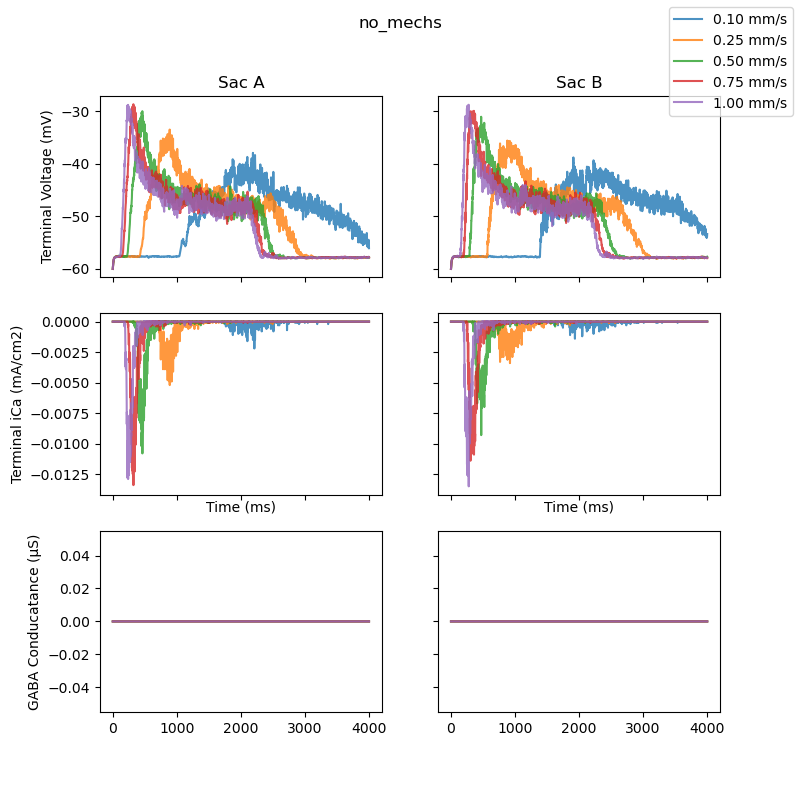

In [29]:
# print(exps[0]["control"].keys())
exp_idx = 0
alpha = .8
rec_figs = {}

for cond, ex in exps[exp_idx].items():
    fig, ax = plt.subplots(3, 2, sharex="col", sharey="row",figsize=(8, 8))
    rec_figs[cond] = {"fig": fig, "ax": ax}
    
    for vel, v_a, v_b, ica_a, ica_b, g_a, g_b in zip(
        velocities,
        np.mean(ex["term"]["a"]["v"], axis=0), 
        np.mean(ex["term"]["b"]["v"], axis=0),
        np.mean(ex["term"]["a"]["ica"], axis=0), 
        np.mean(ex["term"]["b"]["ica"], axis=0),
        np.mean(ex["combined_gaba"]["a"]["g"], axis=0),
        np.mean(ex["combined_gaba"]["b"]["g"], axis=0)
    ):
        ax[0][0].plot(rec_xaxis, v_a, alpha=alpha)
        ax[0][1].plot(rec_xaxis, v_b, alpha=alpha)
        ax[1][0].plot(rec_xaxis, ica_a, alpha=alpha)
        ax[1][1].plot(rec_xaxis, ica_b, alpha=alpha)
        ax[2][0].plot(rec_xaxis, g_a, alpha=alpha)
        ax[2][1].plot(rec_xaxis, g_b, label="%.2f mm/s" % vel, alpha=alpha)

    fig.suptitle(cond)
    ax[0][0].set_title("Sac A")
    ax[0][1].set_title("Sac B")
    ax[0][0].set_ylabel("Terminal Voltage (mV)")
    ax[1][0].set_ylabel("Terminal iCa (mA/cm2)")
    ax[2][0].set_ylabel("GABA Conducatance (μS)")
    ax[1][0].set_xlabel("Time (ms)")
    ax[1][1].set_xlabel("Time (ms)")
    fig.legend()
    fig.show()

### Terminal voltages at select velocities and conditions

<IPython.core.display.Javascript object>


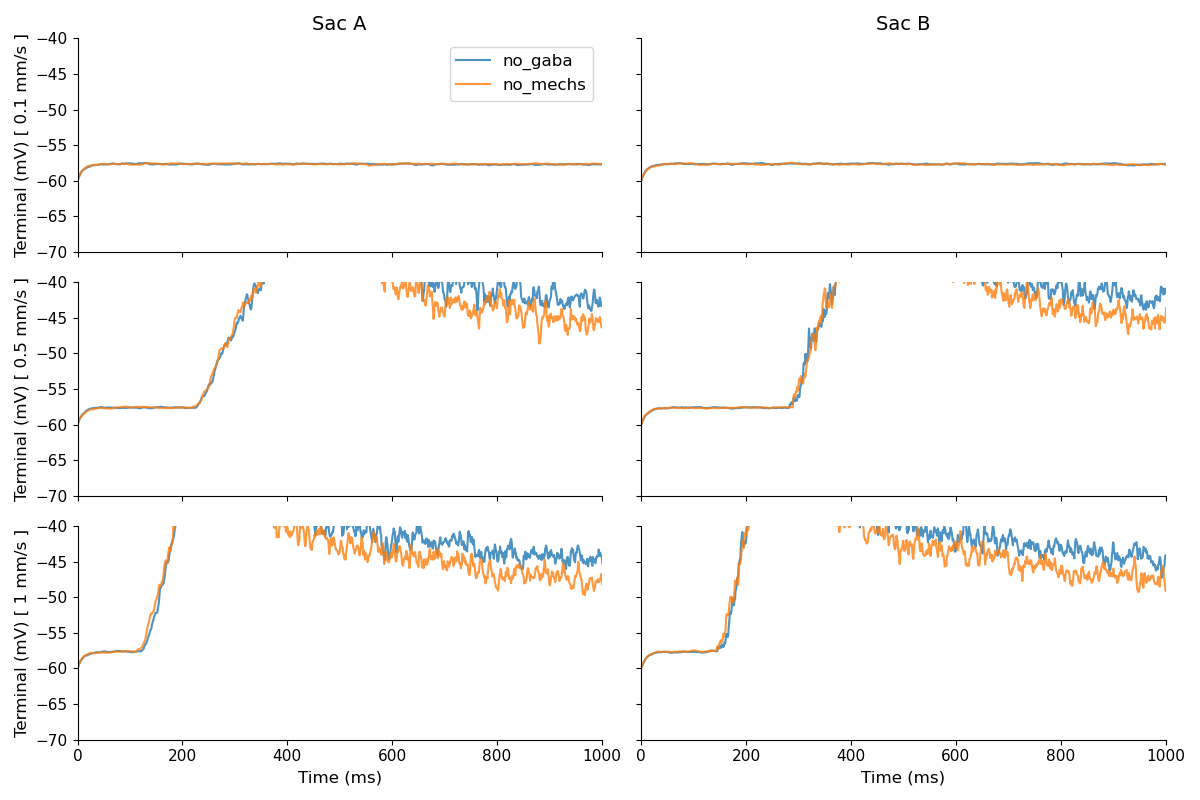

In [30]:
exp_idx = 0
# display_conds = ["control", "uniform", "no_gaba"]
# display_conds = ["uniform", "no_mechs"]
display_conds = ["no_gaba", "no_mechs"]
# display_vel_idxs = [2, 6, -1]
display_vel_idxs = [0, 2, -1]

vm_fig, vm_ax = plt.subplots(
    len(display_vel_idxs),
    2,
    sharex="col",
    sharey="row",
    figsize=(12, 8)
)

for cond in display_conds:
    for i, row in zip(display_vel_idxs, vm_ax):
        row[0].set_ylabel("Terminal (mV) [ %s mm/s ]" % velocities[i], fontsize=12)
        row[0].set_ylim(-70, -40)
        for ax, (n, sac) in zip(row, exps[exp_idx][cond]["term"].items()):
            ax.plot(rec_xaxis, np.mean(sac["v"][:, i], axis=0), label=cond, alpha=.8)
            clean_axes(ax)

for ax in vm_ax[-1]:
    ax.set_xlim(0, 1000)
    
        
vm_ax[0][0].set_title("Sac A", fontsize=14)
vm_ax[0][1].set_title("Sac B", fontsize=14)
vm_ax[-1][0].set_xlabel("Time (ms)", fontsize=12)
vm_ax[-1][1].set_xlabel("Time (ms)", fontsize=12)
vm_ax[0][0].legend(fontsize=12)
vm_fig.tight_layout()
vm_fig.show()

### Testing terminal calcium accumulation mechanism (display for select conditions at chosen velocities)

<IPython.core.display.Javascript object>


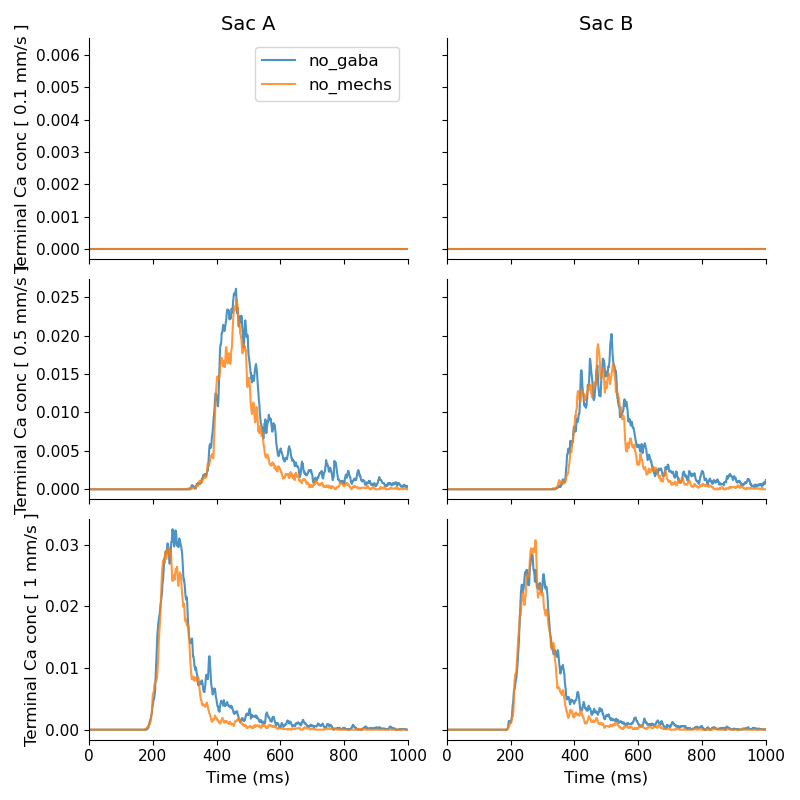

In [31]:
exp_idx = 0
# display_conds = ["control", "uniform", "no_gaba"]
# display_conds = ["uniform", "no_mechs"]
# display_vel_idxs = [2, 6, -1]
display_conds = ["no_gaba", "no_mechs"]
display_vel_idxs = [0, 2, -1]

vm_fig, vm_ax = plt.subplots(
    len(display_vel_idxs),
    2,
    sharex="col",
    sharey="row",
    figsize=(8, 8)
)

for cond in display_conds:
    for i, row in zip(display_vel_idxs, vm_ax):
        row[0].set_ylabel("Terminal Ca conc [ %s mm/s ]" % velocities[i], fontsize=12)
#         row[0].set_ylim(-70, -40)
        for ax, (n, sac) in zip(row, exps[exp_idx][cond]["term"].items()):
            ax.plot(rec_xaxis, np.mean(sac["cai"][:, i], axis=0), label=cond, alpha=.8)
            clean_axes(ax)

for ax in vm_ax[-1]:
    ax.set_xlim(0, 1000)
    
        
vm_ax[0][0].set_title("Sac A", fontsize=14)
vm_ax[0][1].set_title("Sac B", fontsize=14)
vm_ax[-1][0].set_xlabel("Time (ms)", fontsize=12)
vm_ax[-1][1].set_xlabel("Time (ms)", fontsize=12)
vm_ax[0][0].legend(fontsize=12)
vm_fig.tight_layout()
vm_fig.show()

### Second animator instance for creating gifs (if desired)

In [32]:
exp_idx = 0
gif_anim = False
if gif_anim:
    sac_gif_anim = SacSacAnimator(
        exps[exp_idx],
        exp_params[exp_idx], 
        model_params[exp_idx],
        reveal_time=True
    )
    sac_gif_anim_fig, sac_gif_anim_ax1= sac_gif_anim.build_animation_fig(figsize=(8, 12), frameon=False)

In [33]:
if gif_anim:
    params = [
#         {"vel_idx": 0, "n_frames": 150, "dt": 20, "gif_step": 60},
#         {"vel_idx": 1, "n_frames": 150, "dt": 10, "gif_step": 60},
#         {"vel_idx": 5, "n_frames": 100, "dt": 5, "gif_step": 60},
#         {"vel_idx": 8, "n_frames": 150, "dt": 2, "gif_step": 60},
    ]

    for ps in params:
        sac_gif_anim.create_vel_gifs(
            os.path.join(base_path, "gifs"),
            ps["n_frames"],
            vel_idx=ps["vel_idx"],
            dt=ps["dt"],
            dpi=100,
            gif_step=ps["gif_step"],
        )

### GABA and Bipolar conductance alignment over velocity

In [34]:
bp_sums = {i: linear_bp_sum(e) for i, e in avg_exps.items()}
peak_diffs, overlap = {}, {}
for i in avg_exps.keys():
    peak_diffs[i], overlap[i] = {}, {}
    for cond in avg_exps[i].keys():
        peak_diffs[i][cond], overlap[i][cond] = {}, {}
        for sac in ["a", "b"]:
            gaba_peak_i = np.argmax(avg_exps[i][cond]["combined_gaba"][sac]["g"], axis=-1)
            bp_peak_i = np.argmax(bp_sums[i][cond][sac]["g"], axis=-1)
            peak_diffs[i][cond][sac] = (bp_peak_i - gaba_peak_i) * dt
            
            gaba_normed = (
                avg_exps[i][cond]["combined_gaba"][sac]["g"] 
                / (np.sum(avg_exps[i][cond]["combined_gaba"][sac]["g"], axis=-1, keepdims=True) + .00001)
            )
            bp_normed = (
                bp_sums[i][cond][sac]["g"] 
                / (np.sum(bp_sums[i][cond][sac]["g"], axis=-1, keepdims=True) + .00001) 
            )
            overlap[i][cond][sac] = np.sum(gaba_normed * bp_normed, axis=-1)

<IPython.core.display.Javascript object>


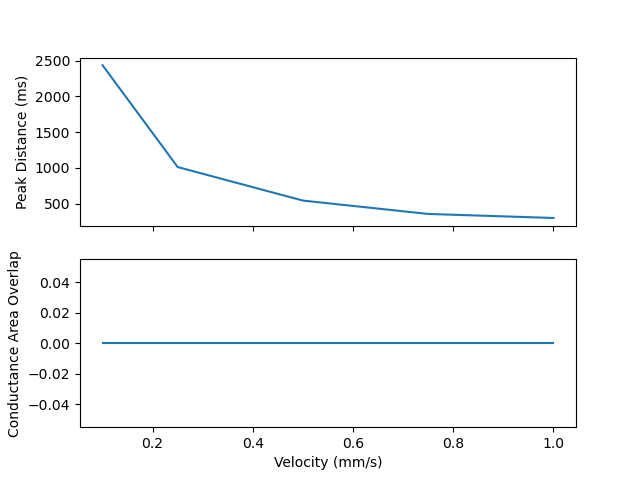

In [35]:
# cond = "control"
cond = "no_gaba"
dist_avg_diffs = np.mean([v[cond]["b"] for v in peak_diffs.values()], axis=0)
dist_avg_overlap = np.mean([v[cond]["b"] for v in overlap.values()], axis=0)

alignment_fig, alignment_ax = plt.subplots(2, sharex=True)
alignment_ax[0].plot(velocities, dist_avg_diffs)
alignment_ax[1].plot(velocities, dist_avg_overlap)


alignment_ax[0].set_ylabel("Peak Distance (ms)")
alignment_ax[1].set_ylabel("Conductance Area Overlap")
alignment_ax[-1].set_xlabel("Velocity (mm/s)")
alignment_fig.show()

In [36]:
# exps[0]["control"].keys()

## TODO: comparisons of excitatory and inhibitory currents to those in vitro

- for excitation, clamping both sacs should be fine
- for GABA, will want to clamp sac b, while a is unclamped

Consider the implications of sink volume on the relationship between amount of conductance / current required to depolarize the model SAC to the levels we expect. If the vc currents measured are much lower than the expected ranges, then it would be an indicator that additional sink dendrites need to be added, and conductance weightings increased, such that the voltages are still as expected, while achieving more realistic currents visible at the soma.

In [37]:
# cond = "control"
cond = "no_gaba"
if "vc" in exps[0][cond]:
    avg_vc_i = np.mean(exps[0][cond]["vc"]["a"], axis=0)
    
    vel_idxs = [0, -1]
    all_soma_vci_avg_fig, all_soma_vci_avg_ax = plt.subplots(1)
    for i in vel_idxs:
        all_soma_vci_avg_ax.plot(rec_xaxis, avg_vc_i[i], alpha=0.5)
        
    all_soma_vci_avg_ax.set_xlim(0)
    all_soma_vci_avg_ax.set_ylabel("clamp current (nA)")
    all_soma_vci_avg_ax.set_xlabel("Time (ms)")
    all_soma_vci_avg_fig.show()

## TODO: low velocity example of DS from sustained and transient quantal bipolar inputs

### Simple Figure:
- inverse fourier deconvolution to rate
- interpolation and input to poisson process to generate quantal event timings
- distribution of BPs along SAC dendrite, activation by simulated edge
- DS without GABA

### Split to 2 figures:

#### 1.
- iGluSnfr proximal and distal recs
- iGluSnfr representative quanta used to do inv FFT to get rates
- rates used to create poisson trains of quanta
- original recordings can be reproduced by summing quantal trains
- add note / demo of how the size of quanta was estimated (quantification and ranges left to supplemental)

#### 2.
- SAC-SAC model schematic (BP input distributions, recording from terminals)
- EPSCs of individual bipolar inputs, and population
- Vm and Ca++ in terminal for SAC A (pref) and B (null)
- PN DS for sust-trans mechanism and transient only.

### Updated figure plan:

#### 1. quantal breakdown
- iGluSnfr proximal dF/F example with rep quanta as is now.
- Release rate from inverse fourier, with discrete quanta example as bar backdrop (for the same single trial as the dF/F example
- second column, some prox and distal single trial discrete quanta examples
- third column distal and proximal isolated inputs (VC) close and far from the soma to show how the filtering makes distal look more sustained. Also, flash response VC (all BPs activated at once)


#### 2. SAC-SAC data
- for bipolar DS and non-DS conditions 
  * SAC-SAC schematic (input locations, indicate bar sweep, average release rates used)
  * bipolar conductance
  * somatic voltage
  * terminal voltage
  * terminal calcium
- DS over range of sust-trans condition (start with control, then one by one, swap sust BPs for trans, moving towards the soma)

<IPython.core.display.Javascript object>


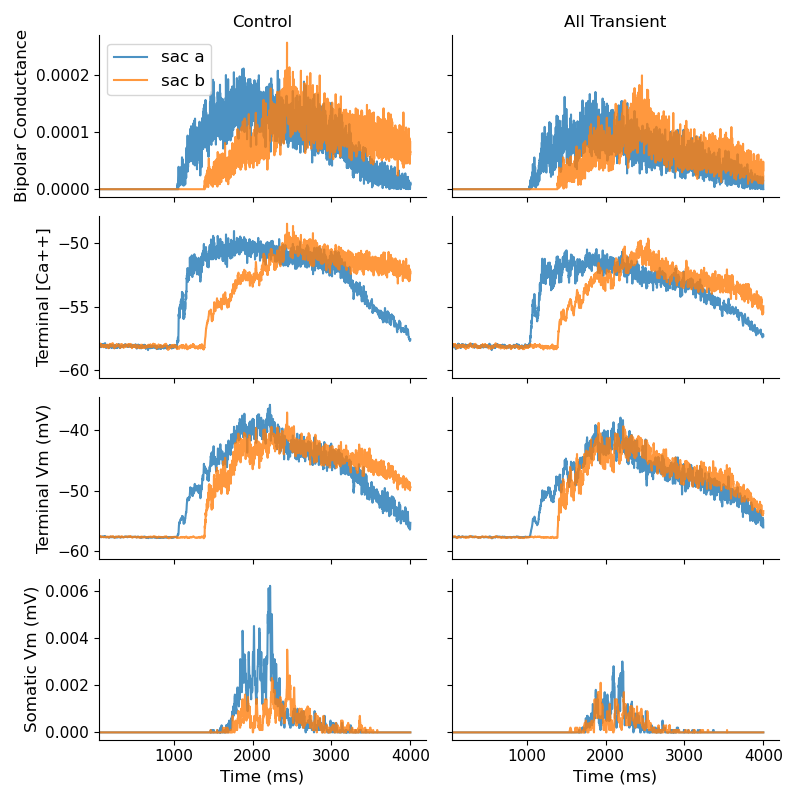

In [38]:
exp_idx = 0
vel_idx = 0
display_conds = ["no_gaba", "no_mechs"]
cond_to_title = {"no_gaba": "Control", "no_mechs": "All Transient"}

ex_fig, ex_ax = plt.subplots(
    4,
    2,
    sharex="col",
    sharey="row",
    figsize=(8, 8)
)

for i, cond in enumerate(display_conds):
    if not i:
        ex_ax[0][i].set_ylabel("Bipolar Conductance", fontsize=12)
        ex_ax[1][i].set_ylabel("Terminal [Ca++]", fontsize=12)
        ex_ax[2][i].set_ylabel("Terminal Vm (mV)", fontsize=12)
        ex_ax[3][i].set_ylabel("Somatic Vm (mV)", fontsize=12)
    
    for n in exps[exp_idx][cond]["term"].keys():
        lbl = "sac %s" % n
        ex_ax[0][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["combined_bps"][n]["g"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        )
        ex_ax[1][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["soma"][n]["v"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        ) 
        ex_ax[2][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["term"][n]["v"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        )
        ex_ax[3][i].plot(
            rec_xaxis, 
            np.mean(exps[exp_idx][cond]["term"][n]["cai"][:, vel_idx], axis=0),
            label=lbl, alpha=.8
        )
    ex_ax[0][i].set_title(cond_to_title[cond])
    ex_ax[-1][i].set_xlabel("Time (ms)", fontsize=12)

for row in ex_ax:
    for col in row:
        clean_axes(col)
        
for ax in ex_ax[-1]:
    ax.set_xlim(50)
    
ex_ax[0][0].legend(fontsize=12)
ex_fig.tight_layout()
ex_fig.show()

/tmp/ipykernel_49652/2817142478.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=(8, 4))


<IPython.core.display.Javascript object>


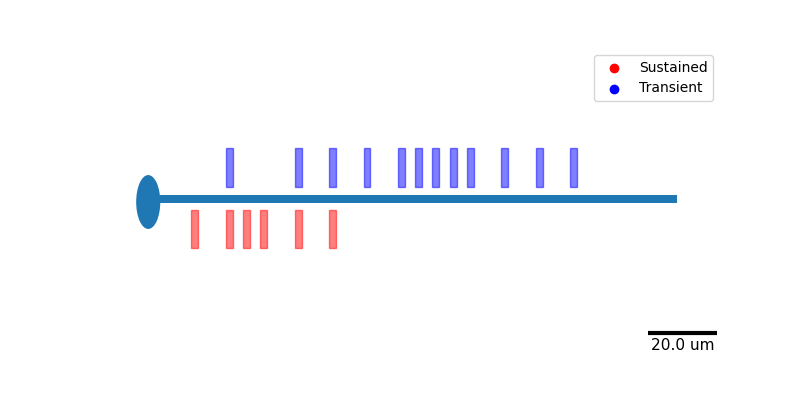

In [43]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ball_sticks(ax, model_params[0], y_off={"a": 0}, bp_width=2, incl_gaba=False)
ax.set_xlim(-100, 80)
ax.set_ylim(-20, 20)
# clean_axes(ax)
add_scalebar(
    ax,
    matchy=False,
    xfmt="%.1f um",
    sep=4,
    barwidth=3,
    fontsize=11,
)